The goal of this notebook is to investigate our 2nd current working hypothesis, which states that peak I(EEG;TIA) optimal lag converges at 500 ms or later. I will try to get this to work with subject 2 for now; if it works I will expand it to other subjects. 

In [1]:
import mne
from pathlib import Path
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns

In [14]:
import sys
from pathlib import Path

# Add the parent directory (which contains "src") to the Python path
sys.path.append(str(Path().resolve().parent / "src"))

from preprocessing_utils import preprocess_subject_data

aud, tac, meta = preprocess_subject_data(
    protocol_folder="P1-20251027T182958Z-1-001/P1",
    subject_num=2,
    apply_bandpass=True,
)

print(aud.shape, tac.shape)
print("Channels:", meta["ch_names"])


Processing subject 2 from P1-20251027T182958Z-1-001/P1...
Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


C:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\src\preprocessing_utils.py:54: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(set_path)


Saved processed data for subject 2 to ..\data\processed\P1_subject2
Shapes — Auditory: (32, 60, 1792), Tactile: (32, 60, 1792)
(32, 60, 1792) (32, 60, 1792)
Channels: ['AF7', 'FPZ', 'AF8', 'AF3', 'AF4', 'F3', 'FZ', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP7', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'POz', 'O1', 'Oz', 'O2']


In [3]:
aud = np.load("../data/processed/P1_subject2_auditory.npy")
tac = np.load("../data/processed/P1_subject2_tactile.npy")
meta = np.load("../data/processed/P1_subject2_meta.npy", allow_pickle=True).item()

print(aud.shape, tac.shape)
print("Channels:", meta["ch_names"])

x_idx = meta["ch_names"].index("C3")
y_idx = meta["ch_names"].index("T7")

x_trials = aud[x_idx]
y_trials = aud[y_idx]

print(x_trials.shape)  # (60, 1792)
print(y_trials.shape)  # (60, 1792)

(32, 60, 1792) (32, 60, 1792)
Channels: ['AF7', 'FPZ', 'AF8', 'AF3', 'AF4', 'F3', 'FZ', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP7', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'POz', 'O1', 'Oz', 'O2']
(60, 1792)
(60, 1792)


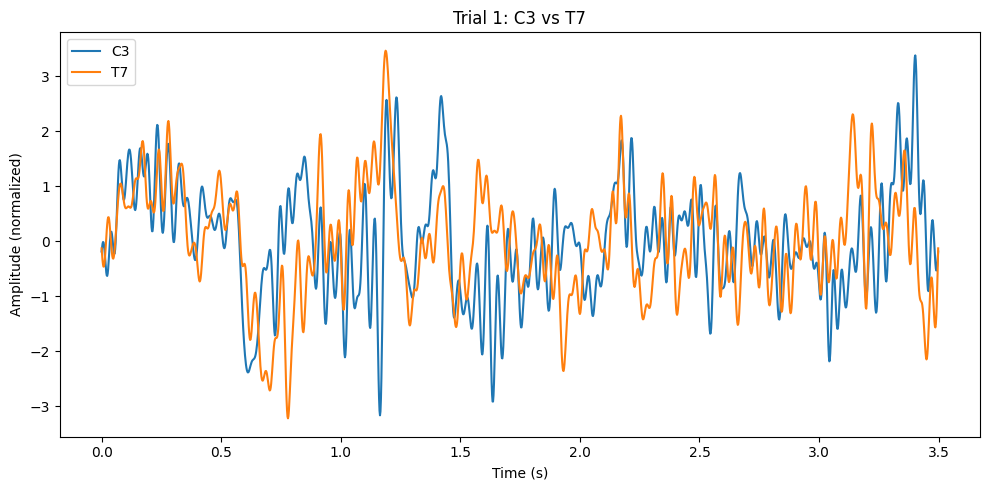

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assume x_trials and y_trials are (n_trials, n_times)
trial = 0
t = np.arange(x_trials.shape[1]) / sfreq  # time in seconds

x_sig = x_trials[trial]
y_sig = y_trials[trial]

plt.figure(figsize=(10, 5))
plt.plot(t, x_sig, label="C3")
plt.plot(t, y_sig, label="T7")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (normalized)")
plt.title(f"Trial {trial+1}: C3 vs T7")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import neural_mi as nmi
import matplotlib.pyplot as plt
from neural_mi.training.trainer import TrainingError

def run_trialwise_mi(
    x_trials, y_trials,
    base_params=None,
    lag_range=None,
    random_seed=42,
    label="Condition",
    ch_pair=None,
):
    """
    Run trial-by-trial Mutual Information vs lag using NeuralMI with fixed
    window size and a wider lag range.
    """

    # --- Default config --- #
    if base_params is None:
        base_params = {
            'embedding_dim': 16,
            'hidden_dim': 32,
            'n_layers': 2,
            'learning_rate': 1e-3,
            'batch_size': 128,
            'n_epochs': 300,
            'patience': 30,
        }
    if lag_range is None:
        lag_range = range(-600, 600, 40 )

    # Sweep grid (critic type etc.)
    sweep_grid = {'critic_type': ['separable']}

    summary = []
    all_curves, all_curves_shuf = [], []
    print(f"Running trial-wise MI ({label}) for {len(x_trials)} trials...")
    
    # --- Trial loop --- #
    for i in tqdm(range(x_trials.shape[0]), desc=f"Trials ({label})"):
        x = x_trials[i][None, :]  # shape (1, timepoints)
        y = y_trials[i][None, :]

        # Skip flat or invalid trials
        if np.std(x) < 1e-6 or np.std(y) < 1e-6:
            print(f"Skipping trial {i+1} (flat signal)")
            continue

        # Shuffle control
        rng = np.random.RandomState(random_seed)
        y_shuf = rng.permutation(y.squeeze())[None, :]

        try:
            # --- NeuralMI run --- #
            res = nmi.run(
                x_data=x, y_data=y,
                mode='lag',
                processor_type_x='continuous', processor_params_x={'window_size': 32},
                processor_type_y='continuous', processor_params_y={'window_size': 32},
                base_params=base_params,
                lag_range=lag_range,
                split_mode='random',  # better for short trials
                n_workers=1, random_seed=random_seed
            )

            res_shuf = nmi.run(
                x_data=x, y_data=y_shuf,
                mode='lag',
                processor_type_x='continuous', processor_params_x={'window_size': 32},
                processor_type_y='continuous', processor_params_y={'window_size': 32},
                base_params=base_params,
                lag_range=lag_range,
                split_mode='random',
                n_workers=1, random_seed=random_seed
            )
        except TrainingError:
            print(f"⚠️ Trial {i+1}: training failed to converge, skipping.")
            continue
        except Exception as e:
            print(f"⚠️ Trial {i+1} crashed: {e}")
            continue

        # --- Extract results --- #
        lags = res.dataframe['lag'].to_numpy()
        mi_vals = res.dataframe['mi_mean'].to_numpy()
        mi_shuf = res_shuf.dataframe['mi_mean'].to_numpy()

        all_curves.append((lags, mi_vals))
        all_curves_shuf.append((lags, mi_shuf))

        max_idx = np.argmax(mi_vals)
        summary.append({
            'trial': i + 1,
            'max_mi': mi_vals[max_idx],
            'opt_lag': lags[max_idx],
            'max_mi_shuf': np.max(mi_shuf)
        })

    # --- Convert to DataFrame --- #
    summary_df = pd.DataFrame(summary)
    print(f"✅ Completed {len(summary_df)} successful trials out of {x_trials.shape[0]}.")

    # --- Plot: max MI per trial --- #
    plt.figure(figsize=(10, 5))
    plt.plot(summary_df['trial'], summary_df['max_mi'], label=f'{label} Original')
    plt.plot(summary_df['trial'], summary_df['max_mi_shuf'], '--', label=f'{label} Shuffled')
    plt.xlabel("Trial")
    plt.ylabel("Max MI (bits)")
    plt.title(f"Maximum MI per Trial ({label}, {ch_pair[0]}–{ch_pair[1]})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot: MI vs Lag (all trials) --- #
    plt.figure(figsize=(10, 5))
    for lags, mi_vals in all_curves:
        plt.plot(lags, mi_vals, color='C0', alpha=0.3)
    for lags, mi_shuf in all_curves_shuf:
        plt.plot(lags, mi_shuf, color='C1', alpha=0.3)
    plt.xlabel("Lag (samples)")
    plt.ylabel("MI (bits)")
    plt.title(f"MI vs Lag (All Trials, {label}, {ch_pair[0]}–{ch_pair[1]})")
    plt.tight_layout()
    plt.show()

    return summary_df, all_curves, all_curves_shuf


In [6]:
summary_df, curves, curves_shuf = run_trialwise_mi(
    x_trials=aud[x_idx],
    y_trials=aud[y_idx],
    label="Auditory",
    ch_pair=("C3", "T7")
)


Running trial-wise MI (Auditory) for 60 trials...


Trials (Auditory):   0%|          | 0/60 [00:00<?, ?it/s]

2025-11-10 14:06:26 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-10 14:06:26 - neural_mi - INFO - Preparing 75 tasks for lag analysis.
2025-11-10 14:06:26 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/75 [00:00<?, ?it/s]

Run lag-750_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-730_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-710_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-690_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-670_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-650_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-630_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-610_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-590_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-570_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-550_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-530_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-510_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-490_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-470_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-450_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-430_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-410_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-390_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-370_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-350_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-330_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-310_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-290_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-270_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-250_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-230_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-210_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-190_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-170_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-150_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-130_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-110_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-90_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-70_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-30_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-10_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag10_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag30_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag70_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag90_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag110_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag130_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag150_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag170_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag190_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag210_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag230_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag250_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag270_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag290_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag310_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag330_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag350_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag370_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag390_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag410_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag430_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag450_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag470_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag490_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag510_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag530_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag550_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag570_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag590_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag610_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag630_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag650_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag670_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag690_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag710_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag730_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

2025-11-10 14:27:32 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-10 14:27:32 - neural_mi - INFO - Preparing 75 tasks for lag analysis.
2025-11-10 14:27:32 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/75 [00:00<?, ?it/s]

Run lag-750_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-730_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-710_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-690_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-670_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-650_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-630_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-610_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-590_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-570_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-550_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-530_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-510_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-490_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-470_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-450_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-430_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-410_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-390_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-370_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-350_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-330_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-310_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-290_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-270_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-250_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-230_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-210_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-190_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-170_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-150_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-130_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-110_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-90_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-70_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-50_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-30_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-10_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag10_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag30_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag50_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag70_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag90_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag110_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag130_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag150_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag170_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag190_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag210_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag230_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag250_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag270_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag290_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag310_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag330_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag350_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag370_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag390_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag410_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag430_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag450_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag470_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag490_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag510_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag530_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag550_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag570_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag590_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag610_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag630_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag650_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag670_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag690_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag710_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag730_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Trials (Auditory):   2%|▏         | 1/60 [23:53<23:29:27, 1433.34s/it]

2025-11-10 14:30:20 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-10 14:30:20 - neural_mi - INFO - Preparing 75 tasks for lag analysis.
2025-11-10 14:30:20 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/75 [00:00<?, ?it/s]

Run lag-750_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-730_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-710_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-690_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-670_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-650_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-630_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-610_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-590_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-570_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-550_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-530_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-510_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-490_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-470_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-450_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-430_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-410_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-390_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-370_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-350_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-330_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-310_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-290_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-270_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-250_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-230_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Trials (Auditory):   2%|▏         | 1/60 [30:39<30:08:43, 1839.39s/it]


KeyboardInterrupt: 